# XGBoost Regression with TensorFlow Pooling and Loss
## Intro
Consider features are available on Individual level, predictions are required also on the Individual level but target is available for Groups of Individuals only.


![picture](img/arch.png)


Predictions of XGBoost on the Individual level will be pooled to the Group level using a custom TensorFlow function. The same function uses one of TensorFlow losses to calculate the final scalar loss by comparing the target  on Group level with the pooled predictions to the Group level.

The goal is to provide a decorator, which turns the mentioned TensorFlow pooling and loss function to the XGBoost custom objective function, such that the whole aggregation and calculation of the 1st and 2nd order derivatives is done seamlessly during XGBoost training.

In [2]:
import numpy as np
import xgboost as xgb
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tf2xgb import get_ragged_nested_index_lists, gen_random_dataset, xgb_tf_loss
from sklearn.metrics import mean_squared_error

## Dummy Input Dataset
Let's generate random "observed" data incl. targets on Individual level. Then, add aggregated targets on Subgroup and Group levels. In the end, we will be able to compare estimates on the Individual-level targets, which is not available in practice in the example above, with the estimates on Subgroup- and Group-level targets.

Note that the aggregation from Individual to Subgroup level is MAX, and the aggregation from the Subgroup to Group level is SUM in this Example.

In [3]:
N = 100000
N_TEST = 10000
N_SUBGRP = N//2
N_GRP = N_SUBGRP//2
BETA_TRUE = [2,1,0,0,0]
SIGMA = 1

In [4]:
# main data frame with features X, subgroup IDs subgrp_id and group ID grp_id;
# target y is NOT observable on the individual level in real data,
# we have it here to be able to simulate target on group level
# and to be able to compared result of the estimate on the group-level
# target with the estimate on the individual level.
df_train = gen_random_dataset(N, N_SUBGRP, N_GRP, BETA_TRUE, SIGMA)
df_test = gen_random_dataset(N_TEST, 0, 0, BETA_TRUE, SIGMA)

In [5]:
df_train.head()

,_row_,X,y,subgrp_id,grp_id
0,0,"[-0.19349239141959665, 0.1391474238260141, -1....",-0.553560,SUBGRP0,GRP23359
1,1,"[-2.0792269520438693, -1.0438943893459143, -0....",-4.454188,SUBGRP1,GRP22453
2,2,"[-0.45026846267016263, -0.5183779204478295, -0...",-0.625037,SUBGRP2,GRP11079
3,3,"[-0.8730921386895838, -1.8773409543759667, 0.1...",-4.934114,SUBGRP3,GRP20702
4,4,"[-0.06896935685529586, 0.6675698736261517, -1....",1.007759,SUBGRP4,GRP24956


In [6]:
X_train = np.asarray(df_train['X'].to_list())
y_train = np.asarray(df_train['y'].to_list())
X_test = np.asarray(df_test['X'].to_list())
y_test = np.asarray(df_test['y'].to_list())

Calculate simulated target `y` on the level of `subgrp_id` (by max pooling of individual-level `y`'s) and `grp_id` (by sum of `subgrp_id`-level `y`'s). 

In [7]:
df_train_subgrp_y = (df_train
    .groupby('subgrp_id')
    .agg({'y':np.max, 'grp_id':max})
    .reset_index()
)

In [8]:
df_train_grp_y = (df_train_subgrp_y
    .groupby('grp_id')
    .agg({'y':np.sum})
    .reset_index()
)

In [9]:
df_train_subgrp_inds = get_ragged_nested_index_lists(df_train, ['subgrp_id'])
df_train_grp_inds = get_ragged_nested_index_lists(df_train, ['grp_id', 'subgrp_id'])

## Custom TF Pooling and Loss Functions

In [10]:
@xgb_tf_loss(df_train_subgrp_inds.sort_values(by=['subgrp_id'])['_row_'].to_list(), 
             df_train_subgrp_y.sort_values(by=['subgrp_id'])['y'].to_numpy())
def xgb_subgrp_obj_fn_from_tf(target, preds_cube):
    """Custom TF Pooling and Loss function.

    This example function performs max pooling from the individual
    level to subgroups.
    The function takes appropriate care of missing values in preds_cube.

    Inputs:
    = target: 1D tensor with target on the level of groups
    = preds_cube: ND tensor with predictions on the individual level;
    the first dimension is that of groups, the other dimensions reflect
    sub-groups on different levels and individual observations
    (target.shape[0] == preds_cube.shape[0]; 
    preds_cube.shape[-1] == max # indiv observations per the most detailed 
    sub-group).
    Missing values are denoted by np.nan and have to be taken care of in 
    this function body. They occur simply because preds_cube
    has typically much more elements that the original flat predictions
    vector from XGBoost.

    Output: scalar tensor reflecting MEAN of losses over all dimensions.
    This is the output of e.g. tf.keras.losses.mean_squared_error().
    The mean is translated to SUM later in tf_d_loss() because of the 
    compatibility with XGB custom objective function.
    """
    x = preds_cube
    # replace NaNs with -Inf: neutral value for reduce_max()
    x = tf.where(tf.math.is_nan(x), tf.constant(-np.inf, dtype=x.dtype), x)
    x = tf.math.reduce_max(x, axis=-1)
    l = tf.keras.losses.mean_squared_error(target, x)
    return l


@xgb_tf_loss(df_train_grp_inds.sort_values(by=['grp_id'])['_row_'].to_list(), 
             df_train_grp_y.sort_values(by=['grp_id'])['y'].to_numpy())
def xgb_grp_obj_fn_from_tf(target, preds_cube):
    """Custom TF Pooling and Loss function.
    
    This example function performs first max pooling from the individual
    level to subgroups, and second sum of subgroups to groups.
    The function takes appropriate care of missing values in preds_cube.

    Inputs:
    = target: 1D tensor with target on the level of groups
    = preds_cube: ND tensor with predictions on the individual level;
    the first dimension is that of groups, the other dimensions reflect
    sub-groups on different levels and individual observations
    (target.shape[0] == preds_cube.shape[0]; 
    preds_cube.shape[-1] == max # indiv observations per the most detailed 
    sub-group)
    Missing values are denoted by np.nan and have to be taken care of in 
    this function body. They occur simply because preds_cube
    has typically much more elements that the original flat predictions
    vector from XGBoost.

    Output: scalar tensor reflecting MEAN of losses over all dimensions.
    This is the output of e.g. tf.keras.losses.mean_squared_error().
    The mean is translated to SUM later in tf_d_loss() because of the 
    compatibility with XGB custom objective function.
    """
    x = preds_cube
    # replace NaNs with -Inf: neutral value for reduce_max()
    x = tf.where(tf.math.is_nan(x), tf.constant(-np.inf, dtype=x.dtype), x)
    x = tf.math.reduce_max(x, axis=-1)
    # replace (-)Inf's (=missing values from reduce_max()) with 0's: 
    # neutral value for reduce_sum()
    x = tf.where(tf.math.is_inf(x), tf.constant(0, dtype=x.dtype), x)
    x = tf.math.reduce_sum(x, axis=-1)
    l = tf.keras.losses.mean_squared_error(target, x)
    return l

## Estimation

In [11]:
dtest = xgb.DMatrix(X_test)

In [12]:
%%time
# labels on Group level are inputs of grouped_objective(), 
# they are not part of dtrain DMatrix
dtrain_subgrp = xgb.DMatrix(X_train)    
regr_subgrp = xgb.train({'tree_method': 'hist', 'seed': 1994},  # any other tree method is fine.
           dtrain=dtrain_subgrp,
           num_boost_round=10,
           obj=xgb_subgrp_obj_fn_from_tf)
# predictions are on Individual level despite the target on Group level
y_subgrp = regr_subgrp.predict(dtest)

CPU times: user 9.59 s, sys: 313 ms, total: 9.9 s
Wall time: 8.08 s


In [13]:
%%time
# labels on Group level are inputs of grouped_objective(), 
# they are not part of dtrain DMatrix
dtrain_grp = xgb.DMatrix(X_train)    
regr_grp = xgb.train({'tree_method': 'hist', 'seed': 1994},  # any other tree method is fine.
           dtrain=dtrain_grp,
           num_boost_round=10,
           obj=xgb_grp_obj_fn_from_tf)
# predictions are on Individual level despite the target on Group level
y_grp = regr_grp.predict(dtest)

CPU times: user 3min 7s, sys: 8.51 s, total: 3min 16s
Wall time: 58.3 s


In [14]:
dtrain_indiv = xgb.DMatrix(X_train, label=y_train)
regr_indiv = xgb.train({'tree_method': 'hist', 'seed': 1994},  # any other tree method is fine.
           dtrain=dtrain_indiv,
           num_boost_round=10
           )
y_indiv = regr_indiv.predict(dtest)

## Results
First, plot the true values vs predictions of both models on the Individual level to see the prediction accuracy:

MSE of individual predictions based on grp_id-pooled targets   : 1.104760634211889
MSE of individual predictions based on subgrp_id-pooled targets: 1.0666397738650766
MSE of individual predictions based on individual targets      : 1.033071328607703


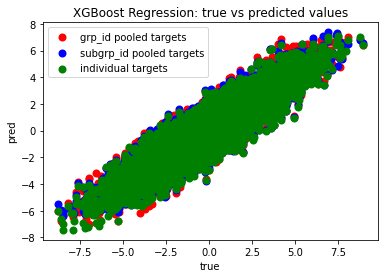

In [15]:
print(f"MSE of individual predictions based on grp_id-pooled targets   : "
      f"{mean_squared_error(y_test, y_grp)}")
print(f"MSE of individual predictions based on subgrp_id-pooled targets: "
      f"{mean_squared_error(y_test, y_subgrp)}")
print(f"MSE of individual predictions based on individual targets      : "
      f"{mean_squared_error(y_test, y_indiv)}")

plt.figure()
plt.scatter(y_test, y_grp, color="red", label="grp_id pooled targets", linewidth=2)
plt.scatter(y_test, y_subgrp, color="blue", label="subgrp_id pooled targets", linewidth=2)
plt.scatter(y_test, y_indiv, color="green", label="individual targets", linewidth=2)
plt.xlabel("true")
plt.ylabel("pred")
plt.title("XGBoost Regression: true vs predicted values")
plt.legend()
plt.show()

The predictions on targets on different levels (individual, subgroup, group) are similarly precise compared to true individual-level target values. Note that MSE<1 is impossible to get because of the unit standard error
in the simulated data.

In ideal case, predictions on the Subgroup- and Group-level targets would be equal to the predictions on Individual-level target. Let's check similarity of both predictions:

0.038243078
0.06462737


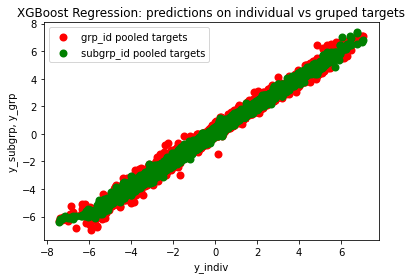

In [16]:
print(mean_squared_error(y_indiv, y_subgrp))
print(mean_squared_error(y_indiv, y_grp))

plt.figure()
plt.scatter(y_indiv, y_grp, color="red", label="grp_id pooled targets", linewidth=2)
plt.scatter(y_indiv, y_subgrp, color="green", label="subgrp_id pooled targets", linewidth=2)
plt.xlabel("y_indiv")
plt.ylabel("y_subgrp, y_grp")
plt.title("XGBoost Regression: predictions on individual vs gruped targets")
plt.legend()
plt.show()

We can see that individual-level predictions using (sub)group-level targets are close to those using the individual-level target, which is in our real setup not available.